#Problem Definitions and Research Questions#

**Background information:** I am a data scientist working for AllLife Bank. The bank aims to expand their market by creating personalized campaigns for potential new customers and improve their bank services for the existing customers.

**Problem definition:** The AllLife Bank needs to have some customer profiles which categorizes and clusters customers based on their similarities and differences, so they can know which type of customer prefers which type of banking service and approach potential new customers based on their preferences.

**Research questions:**

1.   How do existing customers differ from each other in the context of the type of services offered by AllLife Bank? 
2.   How should new customers be approached and which services should the bank highlight the most?
1.   How can AllLife Bank improve each of their services (i.e., online, in-person, call)?








#Data Background and Contents#

##Importing the necessary libraries##

In [ ]:

import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from scipy.stats import zscore

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Reading the file and the preliminary examination of the dataset##

In [ ]:
data=pd.read_excel('/content/drive/MyDrive/credit_card.xlsx')

In [ ]:
cseg=data.copy()

In [ ]:
cseg.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


It seems that there might be someoutliers in average credit limit, because of the values such as 183000 or 68000, but it is difficult to say that by just looking at ten rows. I will explore it further later.

In [ ]:
cseg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


Data type of each feature is numerical which is expected given that all columns include numbers. Also, we see that there is no missing value in any of the column. On the other hand, the two columns Sl_No and Customer Key should be dropped, because they are not used for analysis. Their only purpose is to assign some identifying numbers for customers.

In [ ]:
cseg.drop(['Sl_No','Customer Key'], inplace=True, axis=1)

In [ ]:
cseg.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [ ]:
cseg.duplicated().sum()

11

In [ ]:
# There are 11 duplicated rows, so I need to drop them

cseg.drop_duplicates(inplace=True) # Dropping the duplicate entries from the dataset
cseg.reset_index(drop=True,inplace=True) # We reset the index of the dataframe because some of the rows had been removed (but they will still be there as blank rows, if we do not reset the rows)

##Descriptive Statistics##

In [ ]:
cseg.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,649.0,34878.274268,37813.736638,3000.0,11000.0,18000.0,49000.0,200000.0
Total_Credit_Cards,649.0,4.708783,2.173763,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,649.0,2.397535,1.625148,0.0,1.0,2.0,4.0,5.0
Total_visits_online,649.0,2.624037,2.952888,0.0,1.0,2.0,4.0,15.0
Total_calls_made,649.0,3.590139,2.877911,0.0,1.0,3.0,5.0,10.0


Many of the variables seem to have outliers, because the difference 
between their max value and the value at 75th percentile is big. For example, the value at 75th percentile is 48000 for the variable Acg_Credit_Limit, whereas its max value is 200000. This issue should be explored further.

There is a significant difference between the values of mean and median (50th percentile) in most of the variables such as Avg_Credit_Limit, indicating a potential skewness issues which should be investigated in more detail.

#Exploratory Data Analysis#

In [ ]:
cseg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     649 non-null    int64
 1   Total_Credit_Cards   649 non-null    int64
 2   Total_visits_bank    649 non-null    int64
 3   Total_visits_online  649 non-null    int64
 4   Total_calls_made     649 non-null    int64
dtypes: int64(5)
memory usage: 25.5 KB


##Checking Outliers##

In [ ]:
# The code below returns the 1st and 3rd quantiles and then, it gives the exact values at lower and upper whiskers. We need those values to calculate the number of outliers later.

cseg_boxplots=['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made']

Q1=cseg[cseg_boxplots].quantile(0.25)
Q3=cseg[cseg_boxplots].quantile(0.75)
IQR=Q3-Q1
lower=Q1-1.5*IQR
upper=Q3+1.5*IQR

In [ ]:
# The code below will show us the number and percentage of outliers in each numerical column

print(((cseg[cseg_boxplots]<lower)|(cseg[cseg_boxplots]>upper)).sum())
print('\n')
print(((cseg[cseg_boxplots]<lower)|(cseg[cseg_boxplots]>upper)).sum()/cseg.shape[0]*100)

Avg_Credit_Limit       38
Total_Credit_Cards      0
Total_visits_bank       0
Total_visits_online    37
Total_calls_made        0
dtype: int64


Avg_Credit_Limit       5.855162
Total_Credit_Cards     0.000000
Total_visits_bank      0.000000
Total_visits_online    5.701079
Total_calls_made       0.000000
dtype: float64


The variables Avg_Credit_Limit and Total_visits_online have outliers. 5% in each of the two variables are outliers, which should be explored further and treated if necessary.

##Univariate Analysis and Outlier Detection##

In [ ]:
# I am creating a function that will plot the histogram and the boxplot on the same scale, so it will be easier to analyze the variables one by one.

def histogram_boxplot(data, feature, figsize=(12, 7), kde=True, bins=None):
    """
    data: dataframe which is tour in our case
    feature: dataframe column for numerical variables
    figsize: size of figure
    kde: it shows the density curve
    bins: number of bins for histogram
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color="pink")  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter") if bins else sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2)  # For histogram
    ax_hist2.axvline(data[feature].mean(), color="green", linestyle="--")  # Add mean to the histogram
    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")  # Add median to the histogram

###Avg_Credit_Limit###

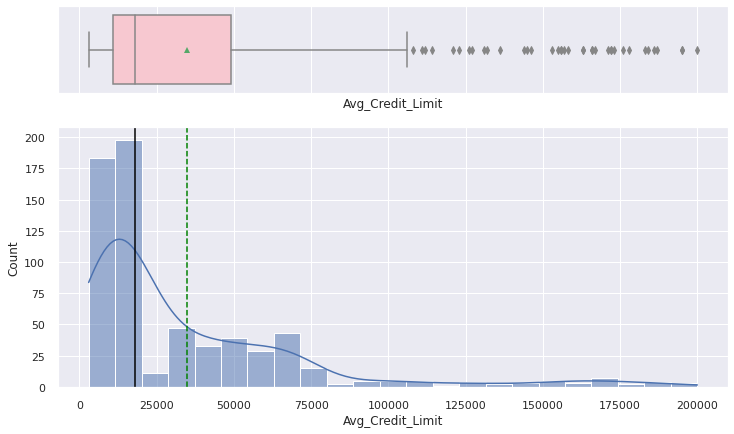

In [ ]:
histogram_boxplot(cseg, 'Avg_Credit_Limit')

In [ ]:
cseg['Avg_Credit_Limit'].skew()

2.1865923911356124

This variable has some variables that contribute to the extremely positive skewness of the distribution. Credit limit above 100000 dollars is very rare in the United States. To explore further, I want to locate the rows with a score of above 100000 in that variable.

In [ ]:
cseg.loc[cseg['Avg_Credit_Limit']>100000]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
601,157000,9,1,14,1
603,163000,8,1,7,1
604,131000,9,1,10,1
606,136000,8,0,13,0
607,121000,7,0,13,2
608,158000,7,0,13,0
609,108000,10,0,15,1
610,166000,9,1,12,2
611,176000,10,1,15,2
612,166000,10,0,7,0


It is interesting that all the scores above 100000 are in the last rows and each of those rows has outlier in another feature Total_visits_online. It is almost as if there is a pattern in outliers. However, I am not sure if I should drop them, because I don't know the currency of the money in this dataset. Is it dollar or something else? If the data was collected in the United States, then I would say that an average credit amount above 100000 did not make sense. But in another country, it may be more meaningful. Also, the outliers might even create their own cluster, which would help AllBank with tailoring their services to the needs of the customers who are outliers.

###Total_Credit_Cards###

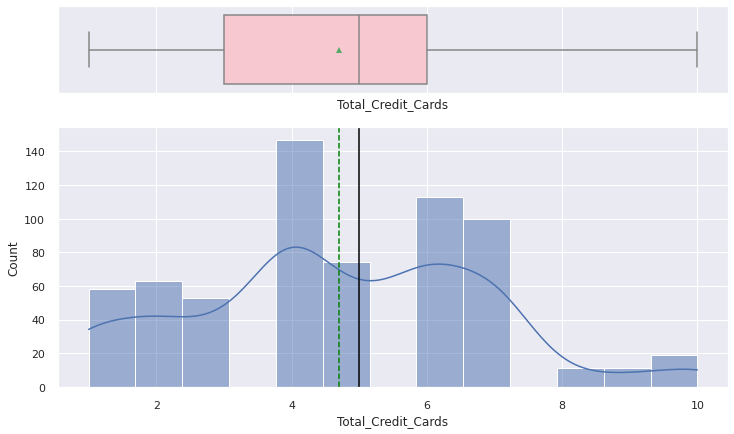

In [ ]:
histogram_boxplot(cseg, 'Total_Credit_Cards')

In [ ]:
cseg['Total_Credit_Cards'].skew()

0.15011990870165423

There are no outliers, and it has few skewness.

###Total_visits_bank###

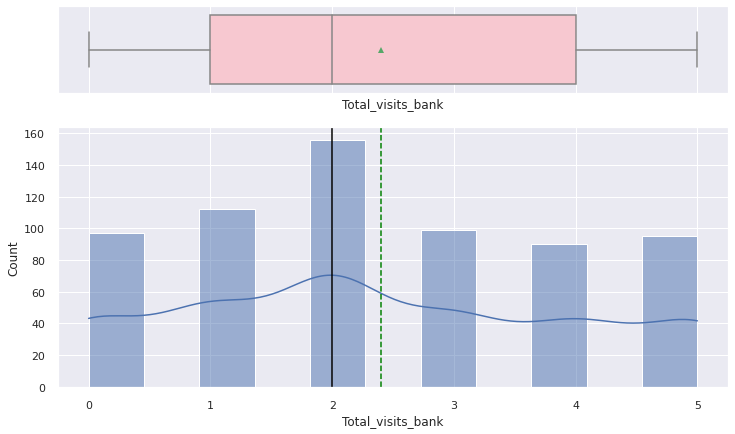

In [ ]:
histogram_boxplot(cseg, 'Total_visits_bank')

In [ ]:
cseg['Total_visits_bank'].skew()

0.1493677785395804

There are no outliers, and it has few skewness.

###Total_visits_online###

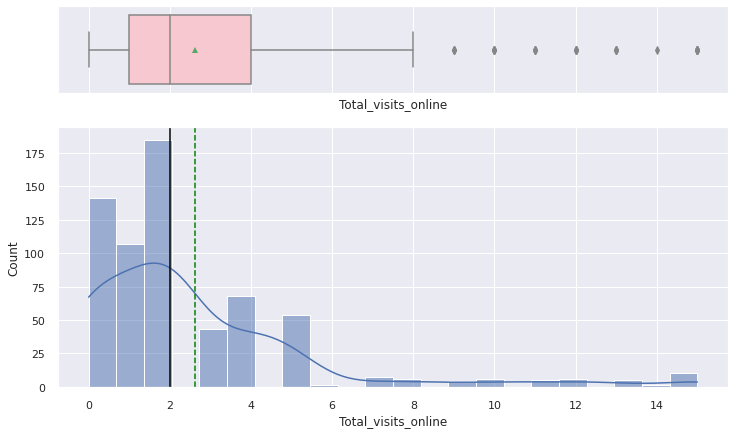

In [ ]:
histogram_boxplot(cseg, 'Total_visits_online')

In [ ]:
cseg['Total_visits_online'].skew()

2.209520923739577

I know that most of the outliers in this variable are in the rows which have outliers in another feature named Avg_Credit_Limit, so it seems like there is a pattern in outliers. I will not drop them, because I do not know to which country this dataset belong.

###Total_calls_made###

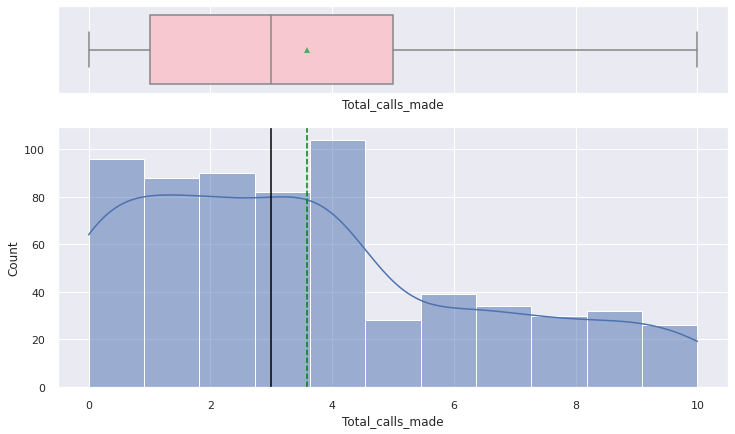

In [ ]:
histogram_boxplot(cseg, 'Total_calls_made')

In [ ]:
cseg['Total_calls_made'].skew()

0.6569540409510178

Although it has moderately positive skewness, it has no outliers, so I will not try to transform it.

##Bivariate Analysis##

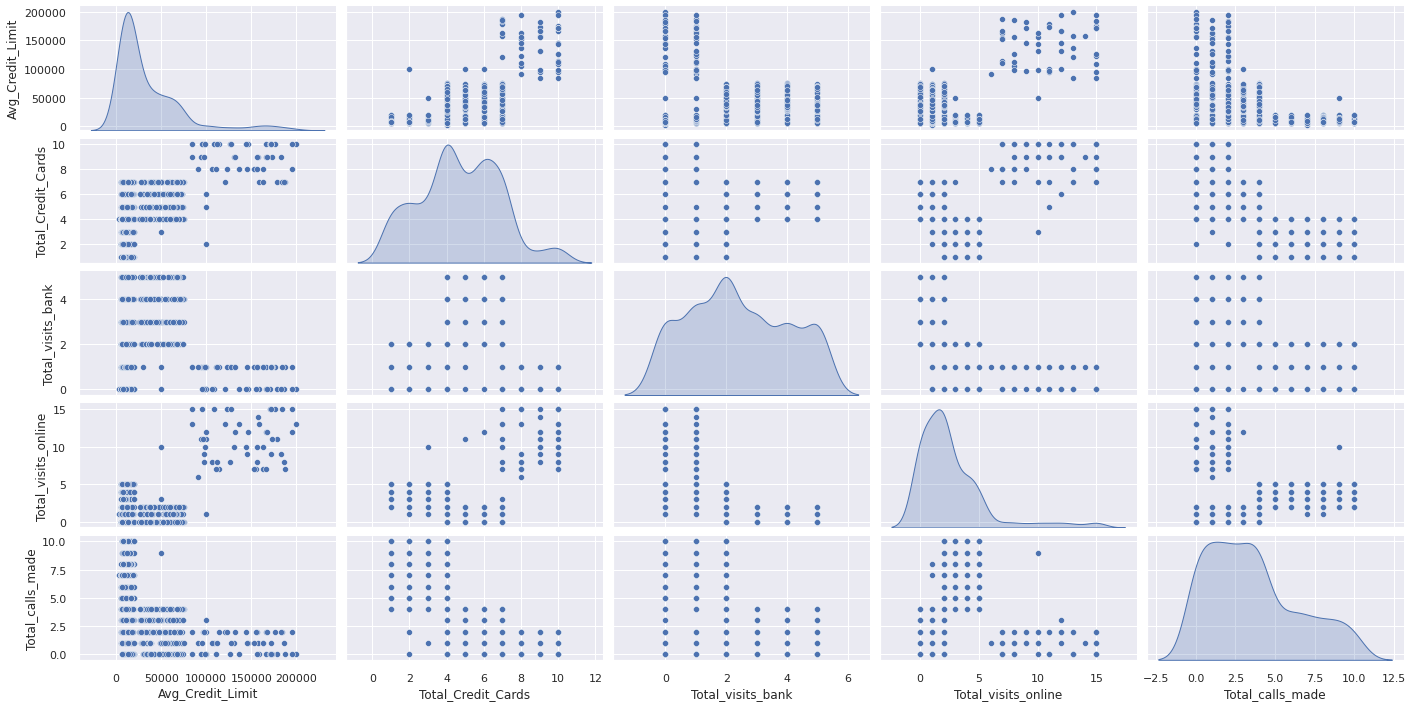

In [ ]:
sns.pairplot(cseg, height=2,aspect=2 , diag_kind='kde')

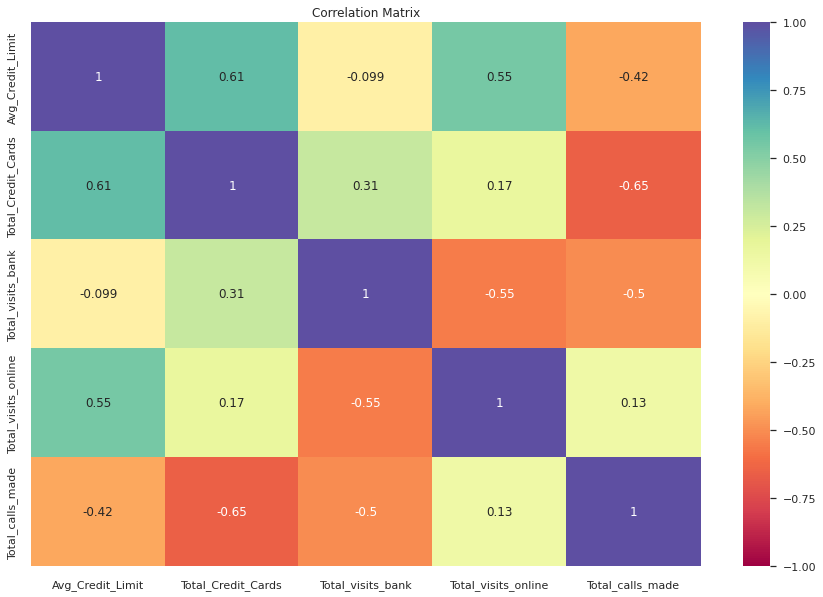

In [ ]:
# Correlation matrix and a heatmap 

plt.figure(figsize=(15,10))
sns.heatmap(cseg.corr(), annot=True, cmap='Spectral', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

There is a high positive correlation between Total Credit Cards and Average Credit Limit (p = 0.61).

There is a high positive correlation between Total Visits Online and Average Credit Limit (p = 0.55)

There is high negative correlation between Total Calls Made and Average Credit Limit (p = -0.42)

There is a high negative correlation between Total Calls Made and Total Credit Cards (p = -0.65)

There is a high negative correlation between Total Calls Made and Total Visits Bank (p = -0.50)

It seems that people who have high average credit limit tend to choose online services instead of calling the bank or visiting the bank. They also tend to have increased number of credit cards. On the other hand, the people who had low or moderate average credit limit tend to visit bank in person or call the bank. 

#Feature Scaling#

Before starting clustering analysis, I have to scale the data, meaning that I have to make the units of each variable same. Why do I do that? It is because clustering is done based on the distance of each pair of variable in each row. However, the measurement of distance may be biased if the units of variables are not the same in a way that higher scores get more weight. It would be like comparing apples and oranges. 

In [ ]:
cseg_scaled=cseg.apply(zscore)
cseg_scaled.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.723499,-1.247087,-0.860606,-0.550407,-1.248443
1,0.400209,-0.786701,-1.476410,2.499808,1.881237
2,0.400209,1.054846,-0.860606,0.127419,0.142526
3,-0.129107,0.134072,-0.860606,-0.550407,0.142526
4,1.723499,0.594459,-1.476410,3.177634,-0.205216
5,-0.393766,-0.786701,-1.476410,-0.550407,1.533495
6,1.723499,0.134072,-1.476410,2.838721,-0.552958
7,-0.526095,-0.786701,-1.476410,-0.550407,-0.900701
8,-0.790753,-1.247087,-1.476410,-0.211494,-0.552958
9,-0.843684,-0.326314,-1.476410,-0.550407,1.185753


Now all the variables are measured based on how many standard deviations they are deviated from the mean of 0.

#K-means Clustering#

I will conduct K-means method for clustering. This method computes a center for a bunch of variables that are close to each other and create clusters based on how close values are to this center.

##Determining Optimal Number of Clusters##

One important decision to make in K-means clustering is determining the optimal number of cluster beforehand, because this method will find out the centers based on the number of cluster that you want to see. But, how will we know the optimal number of cluster in a dataset? Is it 3, 5, 9 or something else? First, we will use the Elbow Method to find the optimal number of cluster.

Number of Clusters: 1 	Average Distortion: 2.007896349270688
Number of Clusters: 2 	Average Distortion: 1.4576197022077821
Number of Clusters: 3 	Average Distortion: 1.1434401208195095
Number of Clusters: 4 	Average Distortion: 1.0435538595477063
Number of Clusters: 5 	Average Distortion: 0.9877797835028078
Number of Clusters: 6 	Average Distortion: 0.9404952836425913
Number of Clusters: 7 	Average Distortion: 0.9202989611913706
Number of Clusters: 8 	Average Distortion: 0.8867882429850815
Number of Clusters: 9 	Average Distortion: 0.8639840623398137


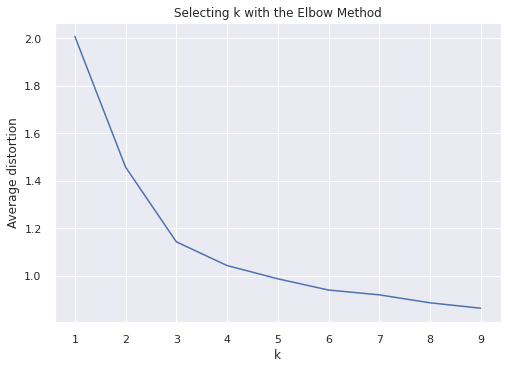

In [ ]:
#The code below will provide the optimal number of clusters for this dataset
#I will use Euclidean as a distance measuring strategy, because K-means always uses that

clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(cseg_scaled)
    prediction = model.predict(cseg_scaled)
    distortion = (
        sum(
            np.min(cdist(cseg_scaled, model.cluster_centers_, 'euclidean'), axis=1)
        )
        / cseg_scaled.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

From the graph above, we see that there is an elbow in K=2 and K=3, meaning that there is a significant distortion there, which might lead to creation of a new cluster. The average distortion numbers for each number of clusters confirm my hypothesis as well. The decline in distortion from K=1 to K=2 and from K=2 to K=3 is significant, indicating a potential incident of clustering.

On the other hand, although the elbow method provided us with some potential leads, it did not produce a certain answer. Therefore, we should use the Silhouette score for each clusters to make sure which is the optimal number of clusters. 

Silhoutte score shows how an object in a cluster is similar to its own cluster and its center. The score ranges from -1 to +1, the former meaning that the object might be assigned to the wrong cluster, whereas the latter meaning that it is very similar to its own cluster.

For n_clusters = 2, silhouette score is 0.41800025566689647
For n_clusters = 3, silhouette score is 0.516281010855363
For n_clusters = 4, silhouette score is 0.3570238219413198
For n_clusters = 5, silhouette score is 0.2722848313346344
For n_clusters = 6, silhouette score is 0.25705756954458703
For n_clusters = 7, silhouette score is 0.24975462891648956
For n_clusters = 8, silhouette score is 0.2267845280296963
For n_clusters = 9, silhouette score is 0.22761957299258687


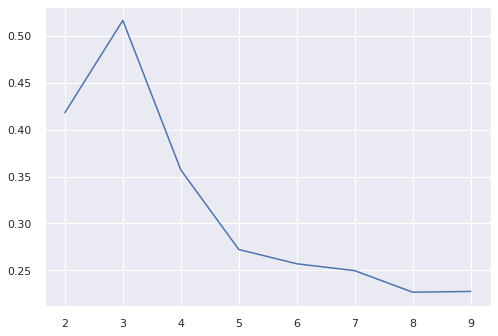

In [ ]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters) 
    preds = clusterer.fit_predict((cseg_scaled)) 
    score = silhouette_score(cseg_scaled, preds)  # Finds the silhouette score
    sil_score.append(score)  # Appends the silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

The silhouette scores for K=2, K=3, and K=4 are closer to +1 compared to other clusters. Therefore, I will check each of these clusters and see if any of them is the optimal number. Before that, I should say that four requirements must be met to claim that a specific number of K is the optimal number. These requirements are the following:



*   Each cluster must have a positive coefficient value
*   Each cluster must have different width and lenght
*   Each cluster must exceed the average silhouette score 
*   Each cluster must have different silhouette score







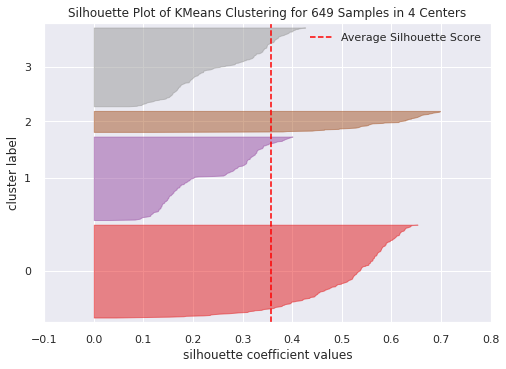

In [ ]:
# First, I will visualize the silhoutte score for k=4 clusters

visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(cseg_scaled)
visualizer.show()

Each cluster has positive coefficient values (checked)

Each cluster exceeded the average silhouette score (checked)

Cluster 1 and Cluster 4 seem to have the same or very similar coefficient values (not checked)

Cluster 1 and Cluster 4 seem to have the same width (not checked)

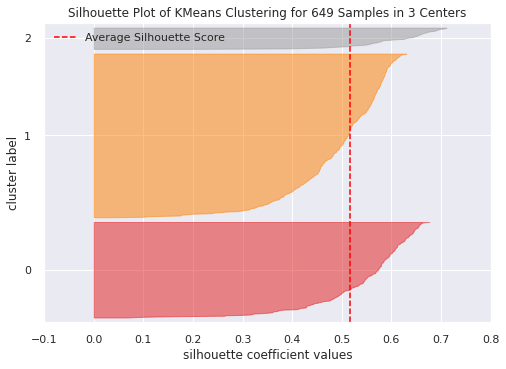

In [ ]:
# Second, I will visualize the silhoutte score for k=3 clusters

visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(cseg_scaled)
visualizer.show()

Each cluster has positive coefficient values (checked)

Each cluster exceeded the average silhouette score (checked)

Each cluster has different coefficient values (checked)

Each cluster has variation (checked)

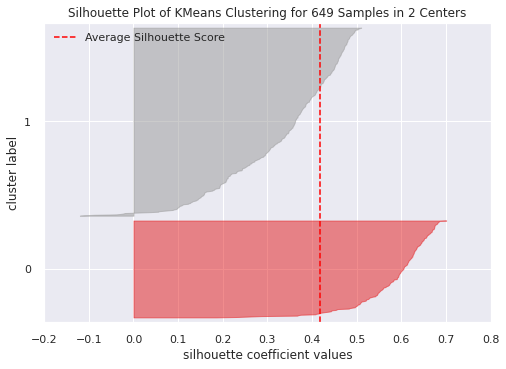

In [ ]:
# Third, I will visualize the silhoutte score for k=2 clusters

visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(cseg_scaled)
visualizer.show()

Cluster 1 has negative coefficient values (not checked)

Each cluster exceeded the average silhouette score (checked)

Each cluster has different coefficient values (checked)

Each cluster has variation (checked)

k=3 meets all the requirements, whereas k=4 or k=2 misses some of them. Also, the elbow graph showed that there was an elbow at k=3. Therefore, 3 is the optimal number of clusters.

##Applying K-means Clustering for k=3##

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(cseg_scaled)

KMeans(n_clusters=3, random_state=0)

In [ ]:
# I will create columns that include kmeans cluster labels, so I will be able to see which row belongs to which cluster
cseg["K_means_segments"] = kmeans.labels_
cseg_scaled["K_means_segments"] = kmeans.labels_

In [ ]:
cseg.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
0,100000,2,1,1,0,1
1,50000,3,0,10,9,2
2,50000,7,1,3,4,1
3,30000,5,1,1,4,1
4,100000,6,0,12,3,0


In [ ]:
cseg_scaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
0,1.723499,-1.247087,-0.860606,-0.550407,-1.248443,1
1,0.400209,-0.786701,-1.476410,2.499808,1.881237,2
2,0.400209,1.054846,-0.860606,0.127419,0.142526,1
3,-0.129107,0.134072,-0.860606,-0.550407,0.142526,1
4,1.723499,0.594459,-1.476410,3.177634,-0.205216,0


As we see, row 0 is in Cluster 1, while row 1 is in Cluster 2, and so on. Now, I can start to profile clusters.

##Cluster Profiling##

In [ ]:
# I will group each variable based on their clusters, showing their mean as well.
cluster_profile = cseg.groupby("K_means_segments").mean()

In [ ]:
# The code below will create a table and highlight the cells that include the highest mean in each variable.
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
K_means_segments,,,,,
0,141040.000000,8.740000,0.600000,10.900000,1.080000
1,34071.428571,5.518519,3.484127,0.981481,1.992063
2,12239.819005,2.411765,0.945701,3.561086,6.891403


I used the original data to create the profiling table above to be able to interpret each variable easier, because the real, non-scaled numbers make more sense. On the other hand, I will use the scaled data to create boxplots below, because boxplots use the same axis, and so, each variable should be standardized. 

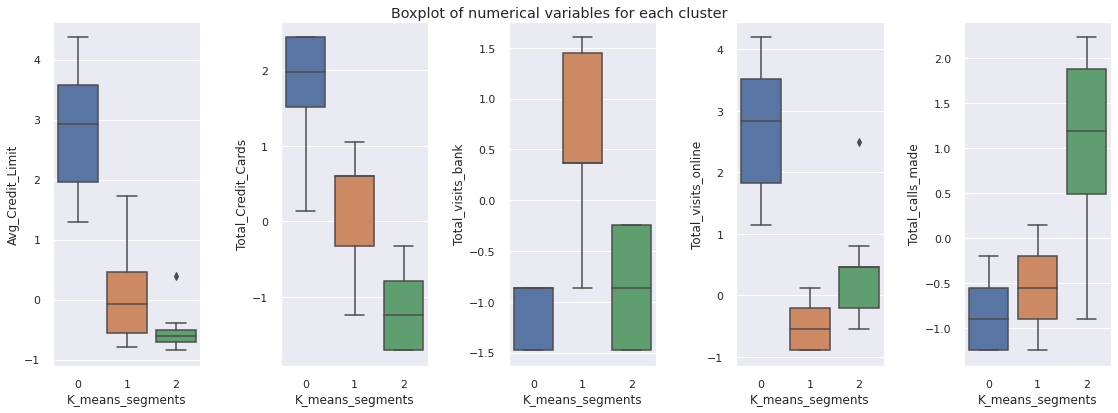

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=cseg_scaled[cseg_boxplots[counter]], x=cseg_scaled["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

##Insights##

**Cluster 1** 

*   This cluster is formed by the outliers of average credit limit and total visits online.
*   The customers in this cluster has most probably high socioeconomic status (average credit limit of the customers in this segment is 141000), because average credit limit is usually positively correlated with one's socioeonomic status. Higher the average credit limit, higher the socioeconomic status.
*   They prefer to use online banking services of AllLife Bank, rather than going to the bank in person or calling the bank. It might be partly due to their high number of credit cards, because using only banking services is more convenient, when one has many credit cards. 

**Cluster 2**

*   The customers in this class is more like the middle class, the average credit limit, which is 34000, being lower than that in cluster 1, but higher than that in cluster 3. 
*   Likewise, the total number of credit cards is somewhere between cluster 1 and cluster 3. 
*   The customers in this cluster are those with the highest number of total visits to the bank, meaning that using the bank services in person is the most popular choice in this customer segment.
*   The use of online banking services is the least preferred in this customer segment compared to other cluster. Also, they do not prefer to use the call services of the bank either, just like the customers in cluster 1.

**Cluster 3**

*   The average credit card limit of the customers in this segment is only 12200, possibly indicating that this segment consists of those with lower socioeconomic status.
*   They tend to have a few credit cards. 
*   The customers in this segment prefer to use call services of the bank rather than online services or visiting the bank in person.















#Hierarhical Clustering#

Second method that I am going to use for clustering is hierarchical clustering. This method creates clusters by computing the distance of each pair of rows, which is why it takes way more time than k-means clustering.

##Finding the cophenetic correlation##


In [ ]:
# I want to see the cophenetic correlation for each combination of distance metrics and linkage methods

distance_metrics = ['euclidean', 'chebyshev', 'mahalanobis', 'cityblock']

linkage_methods = ['single', 'complete', 'average', 'weighted']

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(cseg_scaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(cseg_scaled))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.8978538751523425.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8837002394146526.
Cophenetic correlation for Euclidean distance and average linkage is 0.9100963201569814.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.9052656121003184.
Cophenetic correlation for Chebyshev distance and single linkage is 0.8118063771075958.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8672376803928954.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9086066909752651.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.88484300133361.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.8652242698029384.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.48890770651761006.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8405465466737957.
Cophenetic cor

The highest cophenetic correlation is for Euclidean distance and average linkage, which is 0.91. Therefore, I choose Euclidean distance for my distance metrics. However, I could not use the linkage methods of centroid and ward in the analysis above, because they do not work with the distance metrics other than Euclidean. Now that, I decided to go with Euclidean, I will add those two linkage methods as well to see if the cophenetic correlation score is higher in them.

In [ ]:
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(cseg_scaled, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(cseg_scaled))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.8978538751523425.
Cophenetic correlation for complete linkage is 0.8837002394146526.
Cophenetic correlation for average linkage is 0.9100963201569814.
Cophenetic correlation for centroid linkage is 0.907332941987878.
Cophenetic correlation for ward linkage is 0.7576535233745099.
Cophenetic correlation for weighted linkage is 0.9052656121003184.


We see above that the cophenetic correlation for average linkage is still the highest. Like correlation coefficient, higher the score is, higher the correlation. We should also look the dendograms to see whether the cophenetic correlation between the dendograms and the actual ecludiean distance is similar for each linkage method.

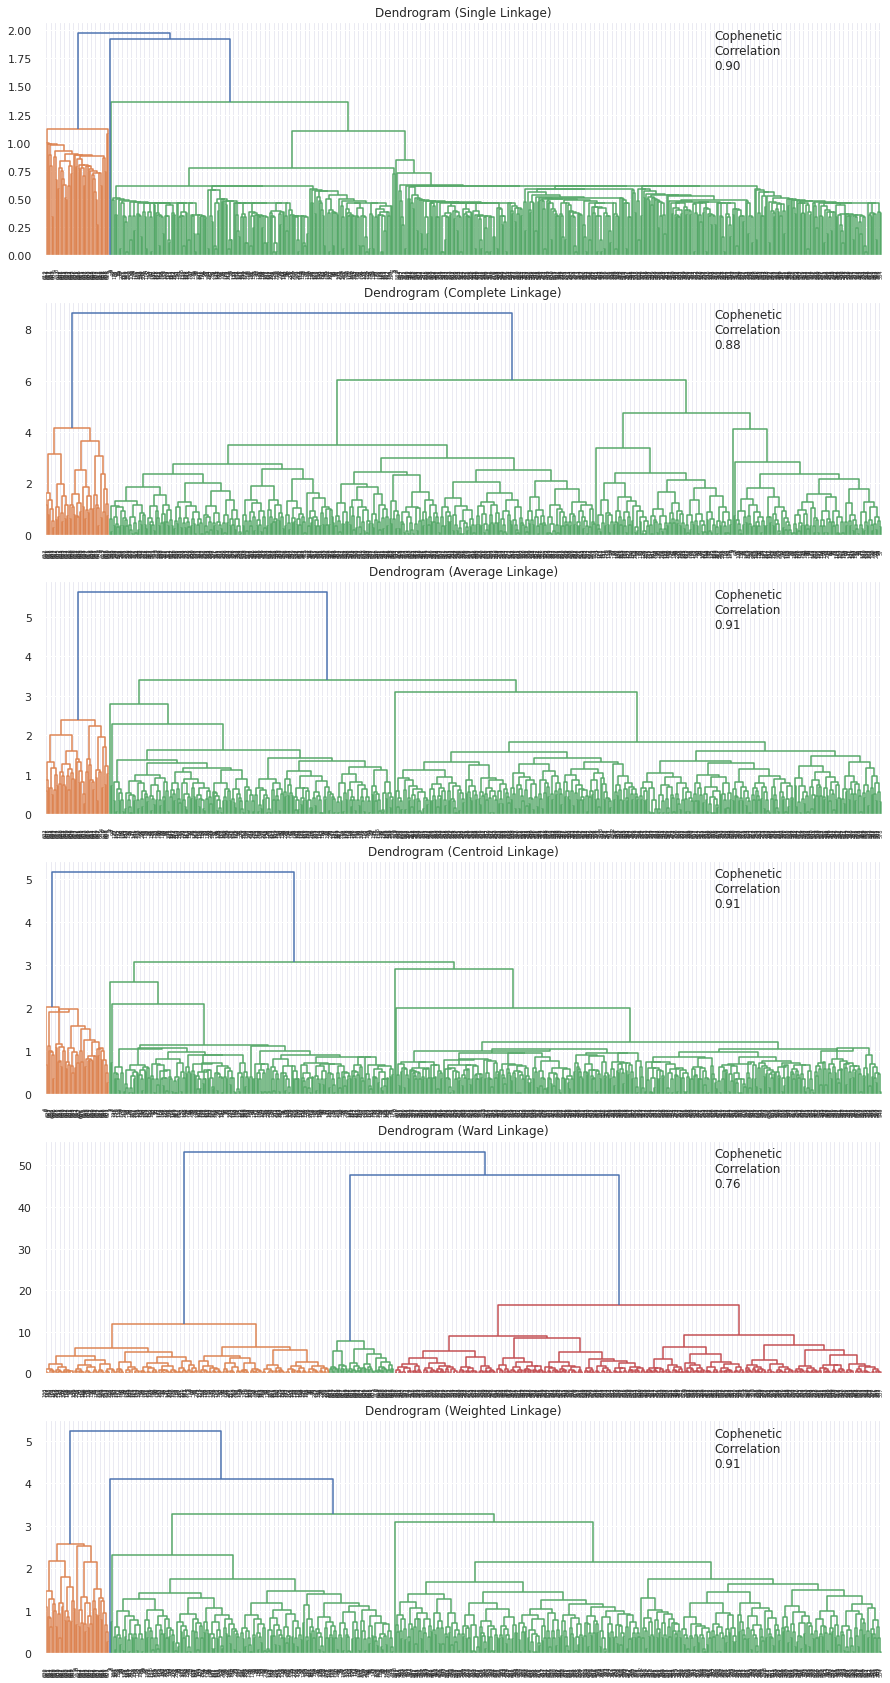

In [ ]:
compare_cols = ["Linkage", "Cophenetic Coefficient"]

fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30)) # This will create a subplot

for i, method in enumerate(linkage_methods):
    Z = linkage(cseg_scaled, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(cseg_scaled))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

The above dendograms show the clusters as well as cophenetic correlation scores. The cophenetic correlation values in the average linkage method are almost the same in both euclidean distance and dendogram. Therefore, we can say that dendogram of average linkage method is the most faithful to the original set of data points.

The optimal number of clusters in the dendogram of average linkage method is three as highlighted with three different colors on the graph. 

##Fitting the Model##

In [ ]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(cseg_scaled)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [ ]:
# Like we did in k-means clustering, we are creating a new column that will include which row is in which cluster
cseg_scaled["HC_Clusters"] = HCmodel.labels_
cseg["HC_Clusters"] = HCmodel.labels_

In [ ]:
cseg.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_Clusters
0,100000,2,1,1,0,1,0
1,50000,3,0,10,9,2,2
2,50000,7,1,3,4,1,0
3,30000,5,1,1,4,1,0
4,100000,6,0,12,3,0,1


In [ ]:
cseg_scaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_Clusters
0,1.723499,-1.247087,-0.860606,-0.550407,-1.248443,1,0
1,0.400209,-0.786701,-1.476410,2.499808,1.881237,2,2
2,0.400209,1.054846,-0.860606,0.127419,0.142526,1,0
3,-0.129107,0.134072,-0.860606,-0.550407,0.142526,1,0
4,1.723499,0.594459,-1.476410,3.177634,-0.205216,0,1


##Hierarchical Cluster Profiling##

In [ ]:
cluster_profile2 = cseg.groupby("HC_Clusters").mean()

In [ ]:
cluster_profile2.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
HC_Clusters,,,,,,
0,34071.428571,5.518519,3.484127,0.981481,1.992063,1.000000
1,141040.000000,8.740000,0.600000,10.900000,1.080000,0.000000
2,12239.819005,2.411765,0.945701,3.561086,6.891403,2.000000


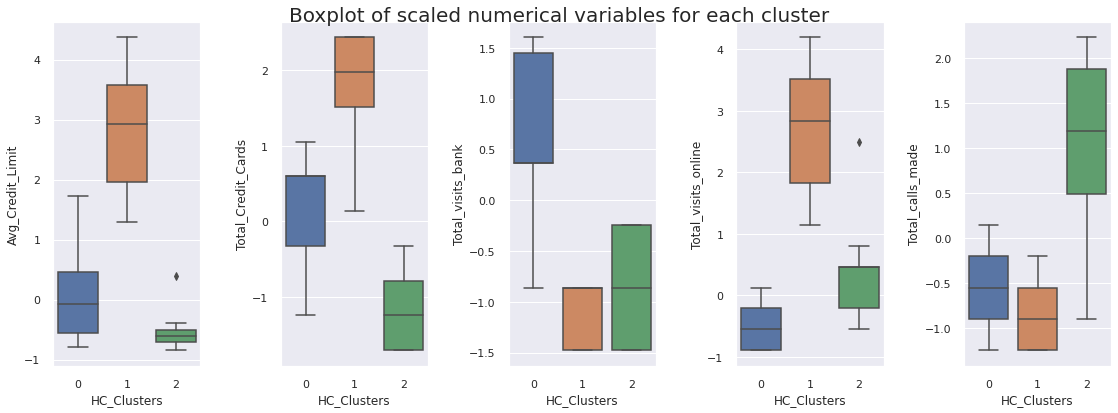

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=cseg_scaled[cseg_boxplots[counter]],
        x=cseg_scaled["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

##Insights##

I will not write a different thing than what I wrote in the Insights section of K-means clustering. It is because the clusters and the customer profiles in each cluster in hierarchical clustering are almost the same as those in k-means clustering. The only difference is that cluster 1 in k-means clustering output is cluster 2 here, and cluster 2 in k-means clustering output is cluster 1 here. Every other things is same or almost the same as the output of k-means clustering. That is most probably due to that the distance method is Euclidean and the optimal number of clusters is 3 in both of them.

**Cluster 1**

*   The customers in this class is more like the middle class, the average credit limit, which is 34000, being lower than that in cluster 2, but higher than that in cluster 3. 
*   Likewise, the total number of credit cards is somewhere between cluster 2 and cluster 3. 
*   The customers in this cluster are those with the highest number of total visits to the bank, meaning that using the bank services in person is the most popular choice in this customer segment.
*   The use of online banking services is the least preferred in this customer segment compared to other cluster. Also, they do not prefer to use the call services of the bank either, just like the customers in cluster 2.

**Cluster 2** 

*   This cluster is formed by the outliers of average credit limit and total visits online.
*   The customers in this cluster has most probably high socioeconomic status (average credit limit of the customers in this segment is 141000), because average credit limit is usually positively correlated with one's socioeonomic status. Higher the average credit limit, higher the socioeconomic status.
*   They prefer to use online banking services of AllLife Bank, rather than going to the bank in person or calling the bank. It might be partly due to their high number of credit cards, because using only banking services is more convenient, when one has many credit cards. 

**Cluster 3**

*   The average credit card limit of the customers in this segment is only 12200, possibly indicating that this segment consists of those with lower socioeconomic status.
*   They tend to have a few credit cards. 
*   The customers in this segment prefer to use call services of the bank rather than online services or visiting the bank in person.

#K-means vs. Hiearchical Clustering#

In the context of this dataset, there was not much difference between k-means and hierarhical clustering. The optimal number of clusters was the same in both of them. The customer profile in each cluster was the same as well, the only difference being in the cluster labels, which is a very minor difference.

A more noticeable difference between those two was that the computing time in hierarchical clustering was higher compared to that in k-means clustering, which is expected. Despite that, I would prefer to use hierarchical clustering for this dataset, because given that all other things (e.g., number of clusters, customer profiles within each cluster) are equal, hierarhical clustering provides me with more option to experiment with. Whereas I have to use euclidean distance in k-means (which is sometimes bad in terms of dealing with outliers), I can use any other distances in hiearchical clustering. Moreover, I do not have set predetermined number of clusters, meaning that I have more space for exploration of the dataset. 

#Business Insights#



*   AllLife Bank should highlight a service, be it online, in-person, or call service, based on a potential customer's annual income. The clustering analysis showed that the segment of customers with the highest average credit limit (hence, those with higher socioeconomic status) preferred online banking services, whereas those the lowest average credit limit (hence, those with lower socioeconomic status) preferred call services. The customers between this two groups preferred in-person visits to the bank. Therefore, I suggest that AllLife Bank should highlight and polish their online services, when a potential customer has such high annual income that it puts the customer into the category of high socioeconomic status. Likewise, they should highlight and emphasize the call services, when a customer has low annual income, and in-person banking, when a customer has moderate annual income.

*   Related to the suggestion above, AllLife Bank should even improve their online services by getting feedback from the existing customers with high average credit limit, their call services by getting feedback from the existing customers with low average credit limit, and their in-person visit services by getting feedback from the existing customers with moderate average credit limit, because each service is preferred by one specific customer profile, as mentioned above. For example, online services can be tailored and improved based on the needs of the wealthy customers, which would in turn increase the satisfaction level of that specific profile from that specific service which they prefer the most. The same logic applies to other two services and two segments of customers as well.

